- ols로 다중회귀분석 수행 후
- SVM과 의사결정회귀나무, XGBoost 사용해서 돌려보기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 데이터 불러오고 전처리

In [ ]:
%cd /content/drive/MyDrive/'멀티캠퍼스 5조'/2.데이터

df = pd.read_csv('학습데이터2.csv')
df.head(3)

/content/drive/.shortcut-targets-by-id/1Mz49-WiynxJxHmmXYuWSqduV3-jd-BC7/멀티캠퍼스 5조/2.데이터


,출발지구군,출발지상세,예정일시,승차일시,시간대_30분,요일,월,화,수,목,금,토,일,언급량,강수량,적설량,평균속도,운행차량수,대기시간,대기시간_초
0,종로구,삼청동,2019-01-01 00:02:00,2019-01-01 04:15:34,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,25.25,11,253.0,15214.0
1,성북구,보문동,2019-01-01 00:13:00,2019-01-01 03:36:11,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,28.31,11,203.0,12191.0
2,강북구,인수동,2019-01-01 00:15:00,2019-01-01 03:23:48,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,24.24,11,188.0,11328.0


In [ ]:
df = df.dropna()

In [ ]:
df['시간대_30분'] = df['시간대_30분'].astype('int')
df['요일'] = df['요일'].astype('int')
#df['요일'] = df['요일'].astype('object')
for feature in df.columns[6:14]:
    df[feature] = df[feature].astype('int')

In [ ]:
df.describe()

,시간대_30분,요일,월,화,수,목,금,토,일,언급량,강수량,적설량,평균속도,운행차량수,대기시간,대기시간_초
count,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06,3.550104e+06
mean,2.448098e+01,2.416291e+00,1.774540e-01,1.783452e-01,1.729144e-01,1.749067e-01,1.702505e-01,7.038076e-02,5.574851e-02,3.773106e+03,1.245874e-01,2.641261e-02,2.295564e+01,3.556373e+02,4.156429e+01,2.518101e+03
std,7.080671e+00,1.759595e+00,3.820525e-01,3.828031e-01,3.781733e-01,3.798873e-01,3.758528e-01,2.557877e-01,2.294355e-01,2.939590e+03,1.231208e+00,2.452691e-01,2.675965e+00,1.361901e+02,2.952999e+01,1.772565e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.040000e+00,1.100000e+01,-1.439000e+03,-8.633000e+04
25%,1.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.775000e+03,0.000000e+00,0.000000e+00,2.130000e+01,2.550000e+02,2.200000e+01,1.323000e+03
50%,2.400000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.039000e+03,0.000000e+00,0.000000e+00,2.272000e+01,3.970000e+02,3.300000e+01,1.981000e+03
75%,2.900000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.742000e+03,0.000000e+00,0.000000e+00,2.424000e+01,4.640000e+02,5.300000e+01,3.234000e+03
max,4.700000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.843500e+04,6.470000e+01,5.500000e+00,4.092000e+01,5.810000e+02,4.970000e+02,2.985100e+04


In [ ]:
df =df.drop(df[df.대기시간 < 0].index)

In [ ]:
df.isna().sum()

출발지구군      0
출발지상세      0
예정일시       0
승차일시       0
시간대_30분    0
요일         0
월          0
화          0
수          0
목          0
금          0
토          0
일          0
언급량        0
강수량        0
적설량        0
평균속도       0
운행차량수      0
대기시간       0
대기시간_초     0
dtype: int64

## box_plot

In [ ]:
df.columns[13:-1]

Index(['언급량', '강수량', '적설량', '평균속도', '운행차량수', '대기시간'], dtype='object')

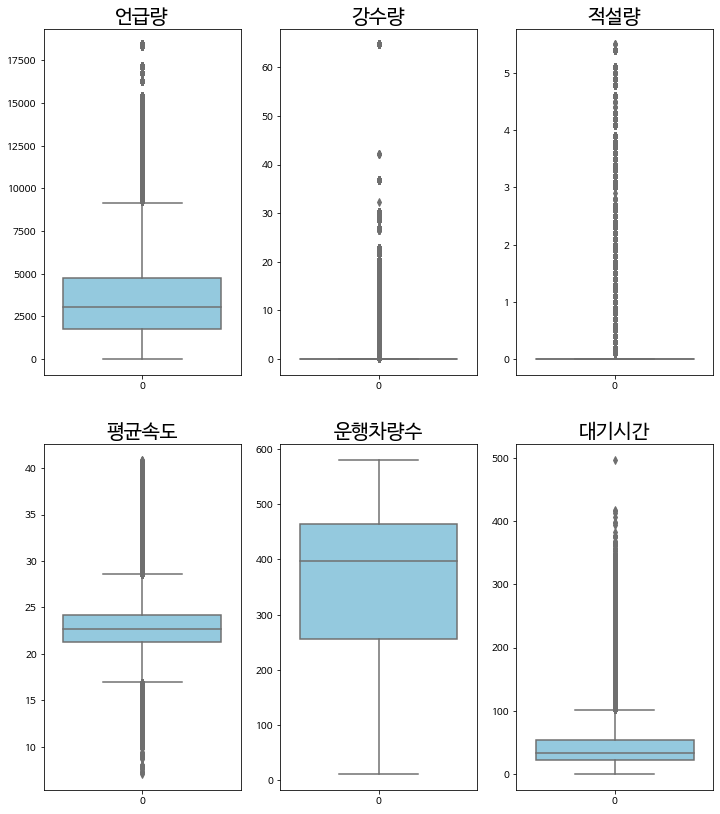

In [ ]:
_, ax = plt.subplots(2, 3, figsize = (12, 14))
for i, feature in enumerate(df.columns[13:-1]):
    row, col = i//3, i%3
    sns.boxplot(data = df[feature], color='skyblue',  ax = ax[row, col])
    ax[row, col].set_title(feature, fontsize = 20)
#plt.savefig('')

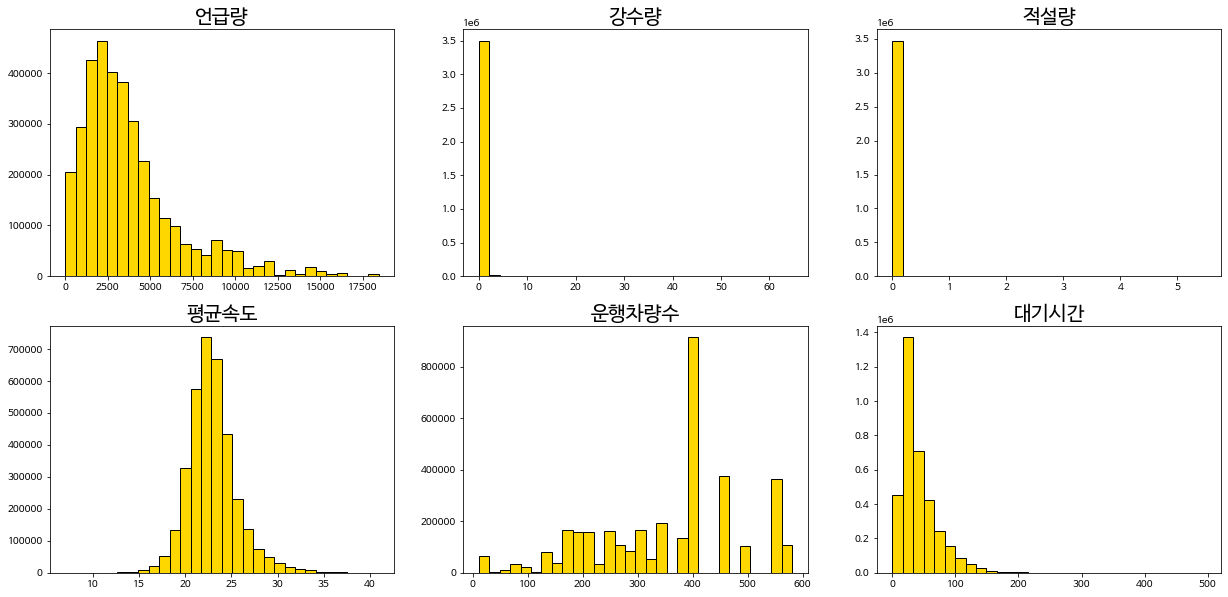

In [ ]:
#lst = [30, 5, 5, 30, 30, ]
_, ax = plt.subplots(2, 3, figsize = (21, 10))
for i, feature in enumerate(df.columns[13:-1]):
    plt.subplot(2,3,i+1)
    plt.hist(df[feature], bins=30, color = 'gold', edgecolor='k')
    plt.title(feature, fontsize = 20)
#plt.savefig('')
plt.show()

### 이상치 찾기

In [ ]:
def find_outliers_tukey(x):
  q1 = np.percentile(x, 25)
  q3 = np.percentile(x, 75)

  iqr = q3-q1
  floor = q1 -1.5*iqr
  ceiling = q3 +1.5*iqr

  max_out = set(x.index[ (x > ceiling) ])
  min_out = list(x.index[ (x < floor) ])
  outlier_indices = list(x.index[ (x < floor)|(x > ceiling) ])
  outlier_values = list(x[outlier_indices])

  return outlier_indices, outlier_values, max_out, min_out, floor, ceiling

In [ ]:
# 대기시간 이상치 확인
ukey_indices, tukey_values, max_out, min_out, floor, ceiling = find_outliers_tukey(df.대기시간)
print(f"비율 : {round(len(ukey_indices) / len(df),4) * 100}\t임계값 : ({floor}, {ceiling})")
print(f"언급량 이상치 index {np.sort(ukey_indices)}") 
# 대기시간 이상치 제거
df = df.drop(ukey_indices)

비율 : 4.66	임계값 : (-26.0, 102.0)
언급량 이상치 index [      0       1       2 ... 3549899 3549908 3550061]


In [ ]:
# 평균속도 이상치 확인
ukey_indices, tukey_values, max_out, min_out, floor, ceiling = find_outliers_tukey(df.평균속도)
print(f"비율 : {round(len(ukey_indices) / len(df), 4) * 100}\t임계값 : ({floor}, {ceiling})")
print(f"평균속도 이상치 index {np.sort(ukey_indices)}") 
# 평균속도 이상치 제거
df = df.drop(ukey_indices)

비율 : 4.18	임계값 : (17.015000000000008, 28.574999999999996)
평균속도 이상치 index [     16      19      21 ... 3550097 3550099 3550101]


In [ ]:
# 언급량 이상치 확인
ukey_indices, tukey_values, max_out, min_out, floor, ceiling = find_outliers_tukey(df.언급량)
print(f"비율 : {round(len(ukey_indices) / len(df), 4) * 100}\t임계값 : ({floor}, {ceiling})")
print(f"대기시간 이상치 index {np.sort(ukey_indices)}")
# 언급량 이상치 제거
df = df.drop(ukey_indices)

비율 : 6.859999999999999	임계값 : (-2552.0, 9264.0)
대기시간 이상치 index [    198     212     340 ... 3549345 3549350 3549422]


In [ ]:
# 강수량 이상치 확인
ukey_indices, tukey_values, max_out, min_out, floor, ceiling = find_outliers_tukey(df.강수량)
print(f"비율 : {round(len(ukey_indices) / len(df), 4) * 100}\t임계값 : ({floor}, {ceiling})")
print(f"강수량 이상치 index {np.sort(ukey_indices)}") 

비율 : 5.25	임계값 : (0.0, 0.0)
강수량 이상치 index [  94943   94946   94947 ... 3539074 3539092 3539093]


In [ ]:
df.shape

(3012638, 20)

In [ ]:
df = df.reset_index(drop = True)

#### Graph

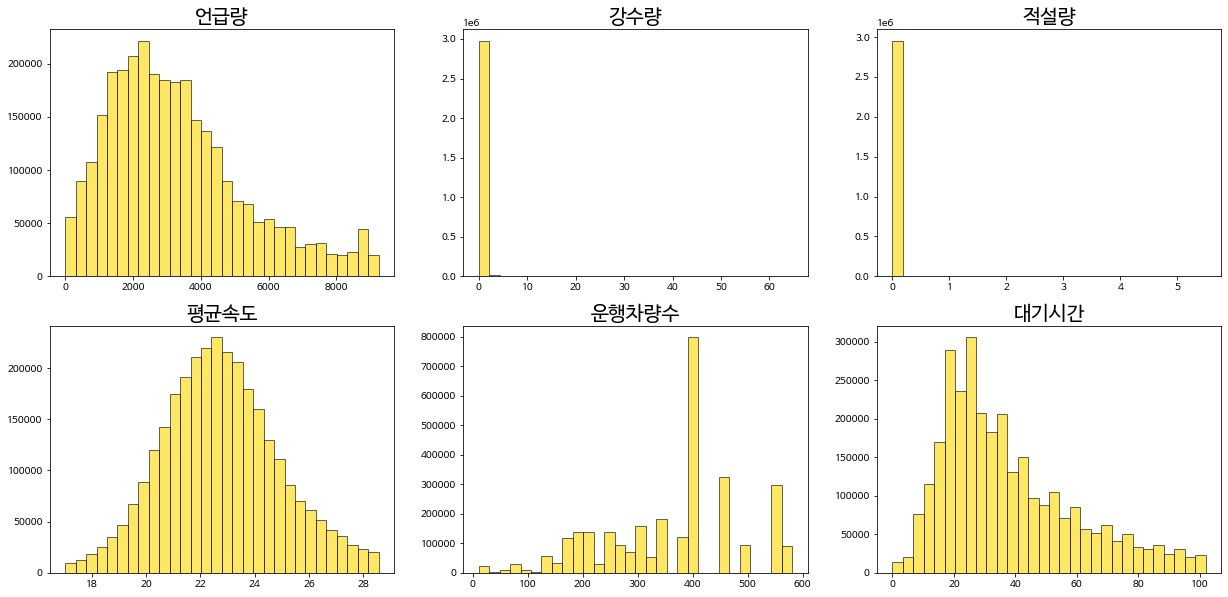

In [ ]:
_, ax = plt.subplots(2, 3, figsize = (21, 10))
for i, feature in enumerate(df.columns[-7:-1]):
    plt.subplot(2,3,i+1)
    plt.hist(df[feature], bins=30, color = 'gold', edgecolor='k', alpha = 0.6)
    plt.title(feature, fontsize = 20)
#plt.savefig('')
plt.show()

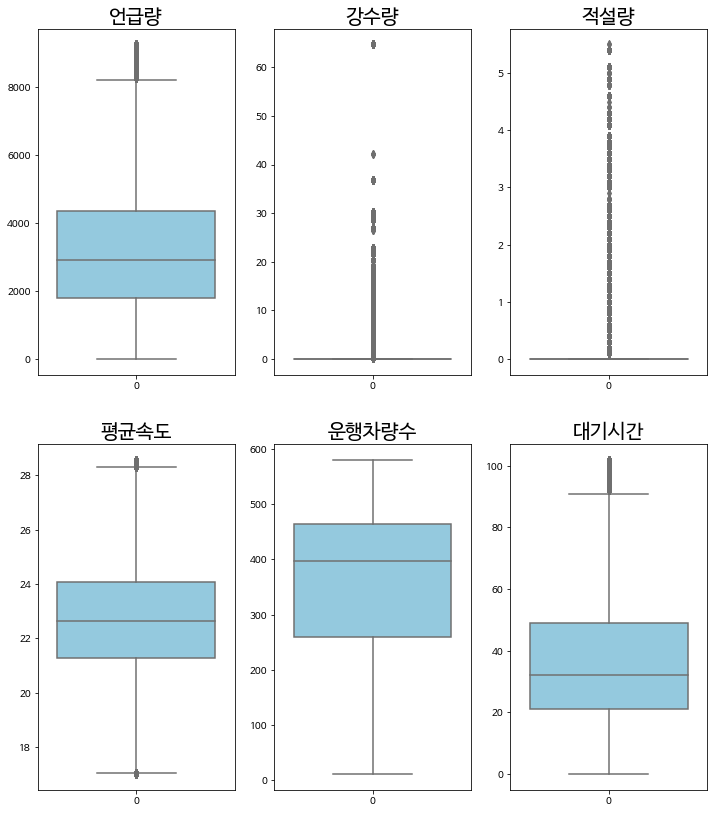

In [ ]:
_, ax = plt.subplots(2, 3, figsize = (12, 14))
for i, feature in enumerate(df.columns[-7:-1]):
    row, col = i//3, i%3
    sns.boxplot(data = df[feature], color='skyblue',  ax = ax[row, col])
    ax[row, col].set_title(feature, fontsize = 20)

In [ ]:
# 이상치 제거 파일 중간 저장
df.to_csv('통합데이터_이상치제거.csv', index = False)

In [ ]:
mon = df2[df2.요일 == 'mon'].groupby('시간대_30분')[['시간대_30분']].count()
tue = df2[df2.요일 == 'tue'].groupby('시간대_30분')[['시간대_30분']].count()
wed = df2[df2.요일 == 'wed'].groupby('시간대_30분')[['시간대_30분']].count()
thr = df2[df2.요일 == 'thr'].groupby('시간대_30분')[['시간대_30분']].count()
fri = df2[df2.요일 == 'fri'].groupby('시간대_30분')[['시간대_30분']].count()
sat = df2[df2.요일 == 'sat'].groupby('시간대_30분')[['시간대_30분']].count()

In [ ]:
lst = ['tue', 'wed', 'thr', 'fri', 'sat']
gp = pd.concat([gp, sat], axis = 1)

In [ ]:
gp = gp.dropna(axis = 1)
all = pd.DataFrame(gp.mean(axis = 1), columns = ['이용량'])

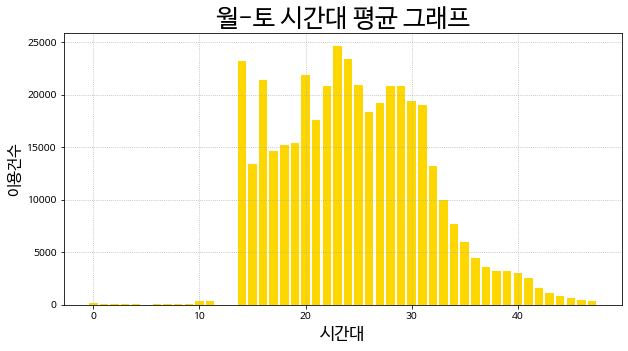

In [ ]:
plt.figure(figsize = (10, 5))
plt.bar(all.index, all['이용량'], color = 'gold')  #, edgecolor='k'
plt.xlabel('시간대', fontsize =17)
plt.ylabel('이용건수', fontsize =15)
plt.title('월-토 시간대 평균 그래프', fontsize =25)
plt.grid(True, linestyle=':')
#plt.savefig('월요일-일요일 시계열 그래프.png', bbox_inches='tight')
plt.show() #주중과 주말의 차이 확인 가능

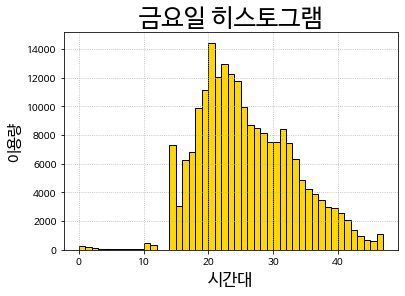

In [ ]:
fri = df2[df2.요일 == 'fri']

plt.hist(fri['시간대_30분'], bins = 47, color = 'gold', edgecolor='k')
plt.xlabel('시간대', fontsize =17)
plt.ylabel('이용량', fontsize =15)
plt.title('금요일 히스토그램', fontsize =25)
plt.grid(True, linestyle=':')
#plt.savefig('월요일-일요일 시계열 그래프.png', bbox_inches='tight')
plt.show() #주중과 주말의 차이 확인 가능

#### 산점도행렬

In [ ]:
test1 = df.iloc[:100000, :]

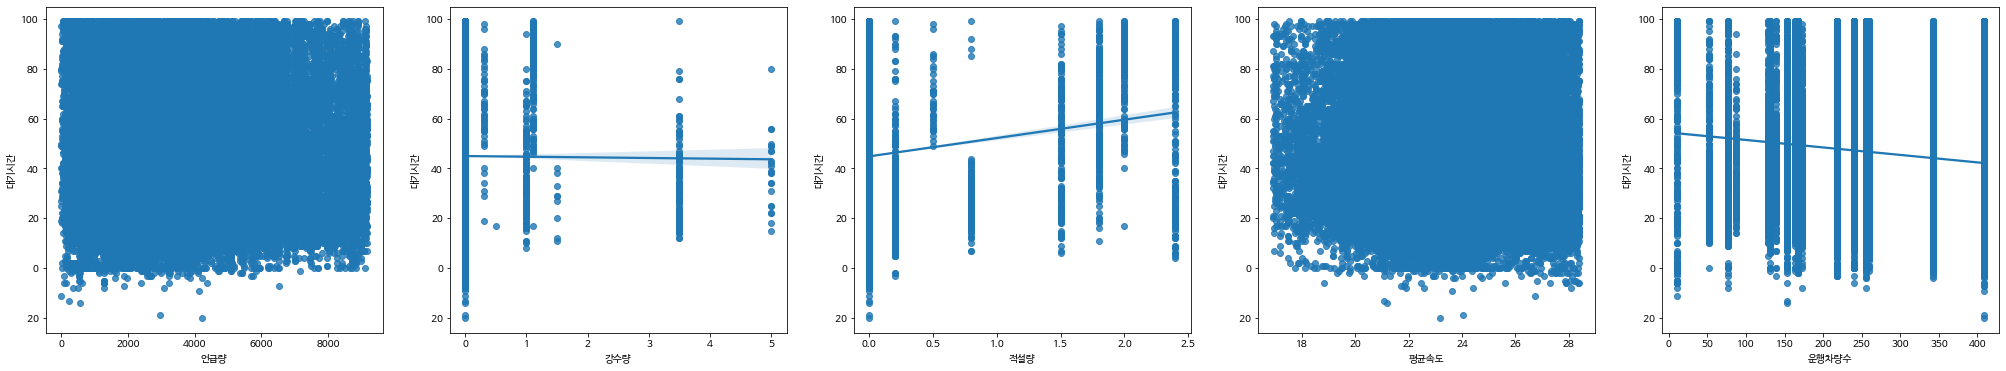

In [ ]:
_, ax = plt.subplots(1, 5, figsize = (35,6))
for i, feature in enumerate(test1.columns[-7:-2]):
    row, col = i//6, i%6
    sns.regplot(x = feature, y = '대기시간', data = test1, ax = ax[col]);
# plt.savefig('모델1 산점도행렬.png', bbox_inches='tight')

### 표준화
- 최대최소정규화
- 언급량, 강수량, 적설량, 평균속도, 운행차량수

In [ ]:
df.columns

Index(['출발지구군', '출발지상세', '예정일시', '승차일시', '시간대_30분', '요일', '월', '화', '수', '목',
       '금', '토', '일', '언급량', '강수량', '적설량', '평균속도', '운행차량수', '대기시간', '대기시간_초'],
      dtype='object')

In [ ]:
temp = df[['언급량', '강수량', '적설량', '평균속도', '운행차량수']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
temp = transformer.fit_transform(temp) #MinMaxScaler 모델에 x_train_df 데이터 적용 (최소값, 최대값 계산)

In [ ]:
temp = pd.DataFrame(temp, columns = ['언급량', '강수량', '적설량', '평균속도', '운행차량수'])

In [ ]:
df = df.drop(['언급량', '강수량', '적설량', '평균속도', '운행차량수'], axis = 1)

In [ ]:
#df.assign(,temp)
df2 = pd.concat([df, temp], axis = 1)
df2.head()

,출발지구군,출발지상세,예정일시,승차일시,시간대_30분,요일,월,화,수,목,금,토,일,대기시간,대기시간_초,언급량,강수량,적설량,평균속도,운행차량수
0,강북구,송천동,2019-01-01 05:20:00,2019-01-01 05:38:53,10,1,0,1,0,0,0,0,0,18.0,1133.0,0.059708,0.0,0.0,0.862338,0.000000
1,은평구,역촌동,2019-01-01 07:00:00,2019-01-01 07:35:42,14,1,0,1,0,0,0,0,0,35.0,2142.0,0.522985,0.0,0.0,0.967965,0.275439
2,도봉구,창제3동,2019-01-01 07:00:00,2019-01-01 07:30:04,14,1,0,1,0,0,0,0,0,30.0,1804.0,0.585398,0.0,0.0,0.890909,0.275439
3,도봉구,쌍문제4동,2019-01-01 07:00:00,2019-01-01 07:19:37,14,1,0,1,0,0,0,0,0,19.0,1177.0,0.318767,0.0,0.0,0.890909,0.275439
4,중구,신당제4동,2019-01-01 07:00:00,2019-01-01 07:14:49,14,1,0,1,0,0,0,0,0,14.0,889.0,0.246512,0.0,0.0,0.945455,0.275439


In [ ]:
df2.columns

Index(['출발지구군', '출발지상세', '예정일시', '승차일시', '시간대_30분', '요일', '월', '화', '수', '목',
       '금', '토', '일', '대기시간', '대기시간_초', '언급량', '강수량', '적설량', '평균속도', '운행차량수'],
      dtype='object')

In [ ]:
df2 = df2[['출발지구군', '출발지상세', '예정일시', '승차일시', '시간대_30분', '요일', '월', '화', '수', '목',
       '금', '토', '일', '언급량', '강수량', '적설량',
       '평균속도', '운행차량수', '대기시간', '대기시간_초']]

In [ ]:
df2.to_csv('통합데이터_표준화.csv', index = False)

In [ ]:
# 상관계수가 0.3 이상인 것 출력
# |0.3| >= 약한 상관관계
# |0.7| >= 강한 상관관계
df_cor = df2[['시간대_30분', '요일', '언급량', '강수량', '적설량', '평균속도',
       '운행차량수', '대기시간']].corr().drop(['대기시간'])[['대기시간']].abs()
df_cor

,대기시간
시간대_30분,0.011636
언급량,0.065646
강수량,0.021328
적설량,0.040697
평균속도,0.084557
운행차량수,0.141871


In [ ]:
df_cor = df2[['시간대_30분', '요일', '월', '화', '수', '목',
       '금', '토', '일', '언급량', '강수량', '적설량', '평균속도',
       '운행차량수', '대기시간']].corr().drop(['대기시간'])[['대기시간']].abs()
df_cor

,대기시간
시간대_30분,0.009674
요일,0.046723
월,0.001028
화,0.028500
수,0.019543
목,0.012518
금,0.011980
토,0.022465
일,0.057275
언급량,0.066297


In [ ]:
temp = df2[['예정일시','시간대_30분', '요일', '월', '화', '수', '목', '금', '토', '일', '언급량', '강수량', '적설량', '평균속도',
       '운행차량수', '대기시간']]
temp['예정일시'] = pd.to_datetime(temp['예정일시'])

In [ ]:
temp.head()

,예정일시,시간대_30분,요일,월,화,수,목,금,토,일,언급량,강수량,적설량,평균속도,운행차량수,대기시간,year
0,2019-01-01 05:20:00,10,1,0,1,0,0,0,0,0,0.059708,0.0,0.0,0.862338,0.000000,18.0,2019
1,2019-01-01 07:00:00,14,1,0,1,0,0,0,0,0,0.522985,0.0,0.0,0.967965,0.275439,35.0,2019
2,2019-01-01 07:00:00,14,1,0,1,0,0,0,0,0,0.585398,0.0,0.0,0.890909,0.275439,30.0,2019
3,2019-01-01 07:00:00,14,1,0,1,0,0,0,0,0,0.318767,0.0,0.0,0.890909,0.275439,19.0,2019
4,2019-01-01 07:00:00,14,1,0,1,0,0,0,0,0,0.246512,0.0,0.0,0.945455,0.275439,14.0,2019


In [ ]:
temp.loc[1,'예정일시'].year

2019

In [ ]:
# 년도 추가 
add_lst = []
for i in tqdm(temp.index):
    add_lst.append(temp.loc[i,'예정일시'].year)
temp['year'] = add_lst

100%|██████████| 3012638/3012638 [01:21<00:00, 37129.24it/s]


In [ ]:
temp.year.unique()

array([2019, 2020, 2021, 2022])

In [ ]:
temp22 = temp[(temp.year == 2022)]
temp22.head()

,예정일시,시간대_30분,요일,월,화,수,목,금,토,일,언급량,강수량,적설량,평균속도,운행차량수,대기시간,year
2671435,2022-01-01 00:05:00,0,5,0,0,0,0,0,1,0,0.006382,0.0,0.0,0.935931,0.021053,45.0,2022
2671436,2022-01-01 00:19:00,0,5,0,0,0,0,0,1,0,0.005516,0.0,0.0,0.935931,0.021053,35.0,2022
2671437,2022-01-01 00:28:00,0,5,0,0,0,0,0,1,0,0.013737,0.0,0.0,0.935931,0.021053,41.0,2022
2671438,2022-01-01 00:28:00,0,5,0,0,0,0,0,1,0,0.013737,0.0,0.0,0.935931,0.021053,41.0,2022
2671439,2022-01-01 01:05:00,2,5,0,0,0,0,0,1,0,0.016225,0.0,0.0,0.925541,0.021053,84.0,2022


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [ ]:
temp22.columns

Index(['예정일시', '시간대_30분', '요일', '월', '화', '수', '목', '금', '토', '일', '언급량',
       '강수량', '적설량', '평균속도', '운행차량수', '대기시간', 'year'],
      dtype='object')

In [ ]:
X = np.array(temp22[['시간대_30분', '요일', '월', '화', '수', '목',
       '금', '토', '일','언급량', '강수량', '적설량', '평균속도', '운행차량수']])
y = np.array(temp22['대기시간'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size= 0.1, random_state=2022
)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
r2_score(y_test,lr.predict(X_test)) 

0.09269474803200772

In [ ]:
xgr = XGBRegressor()
xgr.fit(X_train, y_train)
pred_xgr = xgr.predict(X_test)
r2_xgr= r2_score(y_test, pred_xgr)
mse_xgr = mean_squared_error(y_test, pred_xgr)

r2_xgr, mse_xgr

[05:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.25577185918050593, 261.62742617579914)